In [4]:
import sys
sys.path.append('/content')
import tsa_functions_quantra

In [5]:
%run tsa_functions_quantra.py


/content/tsa_functions_quantra.py:8: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


In [6]:
%load tsa_functions_quantra.py

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf  # You can install this package using: pip install yfinance
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense
import datetime
from tsa_functions_quantra import model_performance

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
# Step 1: Download historical stock price data
data = pd.read_csv("/content/drive/MyDrive/MSFT-10y.csv",delimiter="|")
data = data[-814:]
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
1703,2021-01-04,222.529999,223.000000,214.809998,217.690002,211.605316,37130100
1704,2021-01-05,217.259995,218.520004,215.699997,217.899994,211.809448,23823000
1705,2021-01-06,212.169998,216.490005,211.940002,212.250000,206.317352,35930700
1706,2021-01-07,214.039993,219.339996,213.710007,218.289993,212.188522,27694500
1707,2021-01-08,218.679993,220.580002,217.029999,219.619995,213.481369,22956200


In [19]:
# Step 2: Data preprocessing
def preprocess_data(data):
    # Extract the 'Close' price as our target variable
    df = data[['Close']]

    # Normalize the data to a range between 0 and 1
    scaler = MinMaxScaler()
    df['Close'] = scaler.fit_transform(df['Close'].values.reshape(-1,1))

    return df, scaler

In [20]:
# Step 3: Create sequences for LSTM
def create_sequences(data, sequence_length):
    sequences = []
    target = []
    for i in range(len(data) - sequence_length):
        x = data[i:i+sequence_length]
        y = data[i+sequence_length]
        sequences.append(x)
        target.append(y)
    return np.array(sequences), np.array(target)

In [21]:
# Step 4: Build and train the LSTM model
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=100, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(100, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [26]:
# Preprocess the data
df, scaler = preprocess_data(data)

<ipython-input-19-d1ab49ec2771>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Close'] = scaler.fit_transform(df['Close'].values.reshape(-1,1))


In [45]:
# Define the sequence length and create sequences
sequence_length = 60
sequences, target = create_sequences(df.values, sequence_length)

In [46]:
# Split the data into training and testing sets
train_size = int(len(sequences) * 0.8)
X_train, X_test = sequences[:train_size], sequences[train_size:]
y_train, y_test = target[:train_size], target[train_size:]
print (X_train)
len(X_train)

[[[0.02505528]
  [0.02602245]
  [0.        ]
  ...
  [0.11159726]
  [0.10588617]
  [0.09027269]]

 [[0.02602245]
  [0.        ]
  [0.02781869]
  ...
  [0.10588617]
  [0.09027269]
  [0.10832721]]

 [[0.        ]
  [0.02781869]
  [0.03394434]
  ...
  [0.09027269]
  [0.10832721]
  [0.13863305]]

 ...

 [[0.47443815]
  [0.46794403]
  [0.52353545]
  ...
  [0.50483598]
  [0.49811163]
  [0.48189944]]

 [[0.46794403]
  [0.52353545]
  [0.55563752]
  ...
  [0.49811163]
  [0.48189944]
  [0.48005717]]

 [[0.52353545]
  [0.55563752]
  [0.54789975]
  ...
  [0.48189944]
  [0.48005717]
  [0.50492818]]]


603

In [47]:
# Build the LSTM model
input_shape = (X_train.shape[1], X_train.shape[2])
model = build_lstm_model(input_shape)

In [48]:
# Train the model
model.fit(X_train, y_train, epochs=3, batch_size=1)

Epoch 1/3
603/603 [==============================] - 48s 72ms/step - loss: 0.0033
Epoch 2/3
603/603 [==============================] - 44s 73ms/step - loss: 0.0017
Epoch 3/3
603/603 [==============================] - 45s 75ms/step - loss: 0.0014


In [49]:
# Make predictions on the test data
y_pred = model.predict(X_test)

5/5 [==============================] - 1s 31ms/step


In [50]:
# Inverse transform the predictions to get actual stock prices
y_pred = scaler.inverse_transform(y_pred)
#print (y_test)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))
#print('After: ')
#print(y_test)

In [55]:
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_pacf
from math import sqrt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
plt.style.use('seaborn-darkgrid')

<ipython-input-55-b7ae1c6d4570>:8: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


In [56]:
# Calculate and print the Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
rmse = np.sqrt(np.mean(y_pred - y_test)**2)
print(f'Root Mean Squared Error: {rmse}')
result = pd.DataFrame(y_test, columns = ['Actual'])
result2 = pd.DataFrame(y_pred, columns = ['Predicted'])
final_result = pd.concat([result,result2], axis=1)
print(final_result)

#model_performance(final_result['Actual'],final_result['Predicted'])

Mean Squared Error: 28.37336184704883
Root Mean Squared Error: 2.722574196114439
         Actual   Predicted
0    327.000000  326.822327
1    319.970001  330.165192
2    322.980011  328.293243
3    323.700012  327.909821
4    328.410004  328.250153
..          ...         ...
146  428.739990  429.250824
147  422.859985  430.601685
148  421.649994  427.070862
149  421.429993  424.127899
150  420.720001  422.927673

[151 rows x 2 columns]


In [57]:
observed = result
predicted = result2

In [61]:
# Mean Absolute Error
mae = mean_absolute_error(observed, predicted)
print('The Mean Absolute Error is %.2f' % mae)

# Mean Squared Error
mse = mean_squared_error(observed, predicted)
print('The Mean Squared Error is %.2f' % mse)

# Root Mean Squared Error
rmse = sqrt(mean_squared_error(observed, predicted))
print('The Root Mean Squared Error is %.2f' % rmse)

# Mean Absolute Percentage Error
mape = 100 * ((observed-predicted)/observed).abs().mean()
#print('The Mean Absolute Percentage Error is %.2f' % mape)

The Mean Absolute Error is 4.26
The Mean Squared Error is 28.37
The Root Mean Squared Error is 5.33


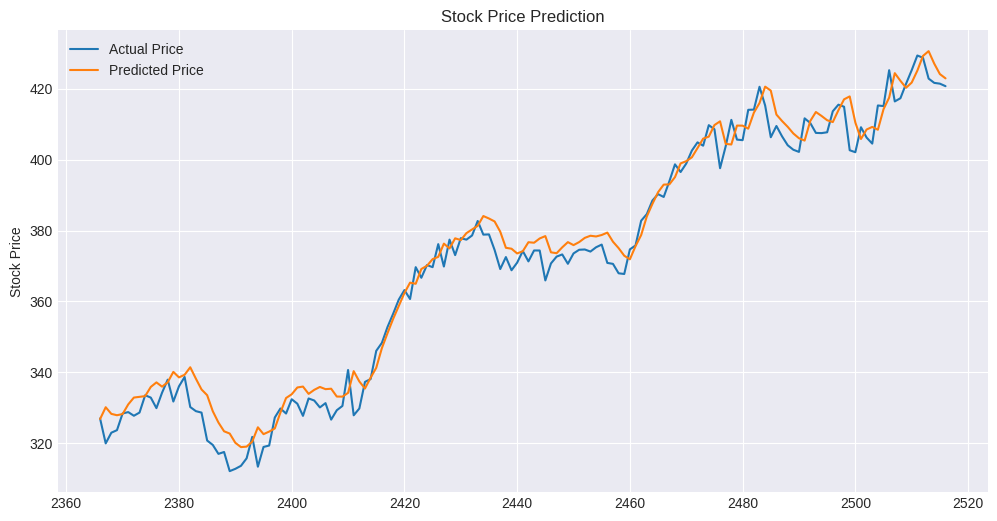

In [63]:
plt.figure(figsize=(12, 6))
plt.plot(data.index[train_size+sequence_length:], y_test, label='Actual Price')
plt.plot(data.index[train_size+sequence_length:], y_pred, label='Predicted Price')
plt.title('Stock Price Prediction')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [65]:
# Step 5: Main function for stock price prediction
#def main():
    # Define the stock symbol, start date, and end date
    symbol = 'MSFT'
    #start_date = '2015-01-01'
    #end_date = datetime.date.today()
    #end_date = '2023-01-01'

    # Download historical stock data
    #data = pd.read_csv("/content/yfin test file.txt",delimiter="|")

    # Preprocess the data
    df, scaler = preprocess_data(data)

    # Define the sequence length and create sequences
    sequence_length = 10
    sequences, target = create_sequences(df.values, sequence_length)

    # Split the data into training and testing sets
    train_size = int(len(sequences) * 0.8)
    X_train, X_test = sequences[:train_size], sequences[train_size:]
    y_train, y_test = target[:train_size], target[train_size:]

    print (X_train)
    # Build the LSTM model
    input_shape = (X_train.shape[1], X_train.shape[2])
    model = build_lstm_model(input_shape)

    # Train the model
    model.fit(X_train, y_train, epochs=3, batch_size=1)

    # Make predictions on the test data
    y_pred = model.predict(X_test)

    # Inverse transform the predictions to get actual stock prices
    y_pred = scaler.inverse_transform(y_pred)
    #print (y_test)
    y_test = scaler.inverse_transform(y_test.reshape(-1, 1))
    print('After: ')
    #print(y_test)

    # Calculate and print the Mean Squared Error (MSE)
    mse = mean_squared_error(y_test, y_pred)
    print(f'Mean Squared Error: {mse}')
    rmse = np.sqrt(np.mean(y_pred - y_test)**2)
    print(f'Root Mean Squared Error: {rmse}')
    result = pd.DataFrame(y_test, columns = ['Actual'])
    result2 = pd.DataFrame(y_pred, columns = ['Predicted'])
    final_result = pd.concat([result,result2], axis=1)
    print(final_result)

    model_performance(final_result['Actual'],final_result['Predicted'])

    # Plot the actual vs. predicted stock prices
    plt.figure(figsize=(12, 6))
    plt.plot(data.index[train_size+sequence_length:], y_test, label='Actual Price')
    plt.plot(data.index[train_size+sequence_length:], y_pred, label='Predicted Price')
    plt.title(f'{symbol} Stock Price Prediction')
    plt.xlabel('Date')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()

if __name__ == "__main__":
    main()

IndentationError: unexpected indent (<ipython-input-65-828a3be62962>, line 4)